The evaluation logic for a full conversation is a two-stage process designed to simulate a more nuanced decision:

- High-Confidence "Knock-out" Decision: If any single turn in a conversation is classified with a very high probability, its class is immediately assigned to the entire conversation.

- Majority Vote: If no single turn is decisive, a majority vote is performed on all turns that meet a minimum confidence threshold. The most frequent class among these "qualified" turns becomes the final label.

In [1]:
# SECTION 1: PROJECT CONFIGURATION AND IMPORTS

import pandas as pd
import numpy as np
import json
import os
import time
import random
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from typing import Dict, Any, List
import sys


sys.path.append(os.path.abspath(os.path.join('..')))
from config import (
    PROCESSED_DATA_DIR,
    TRAIN_FILE,
    VAL_FILE,
    TEST_FILE,
    TEXT_COLUMN,
    PERSON_COUPLE_COLUMN,
    RANDOM_STATE
)
print("Configuration variables imported from config.py.")


# --- Set seeds for reproducibility ---
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

print("Configuration complete.")

Configuration variables imported from config.py.
Configuration complete.


In [2]:
# file path for merged train and test data
# TRAIN_FILE, TEST_FILE = "train_merged.json", "test_merged.json"

In [3]:
# SECTION 2: DATA LOADING AND PREPARATION

def create_turn_dataset(file_paths: List[str]) -> pd.DataFrame:
    """
    Loads one or more JSON files, flattens the dialogues into individual turns,
    and returns a single DataFrame.
    """
    turn_data = []
    for file_path in file_paths:
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            for conversation in data:
                label = conversation[PERSON_COUPLE_COLUMN]
                for turn in conversation['dialogue']:
                    turn_data.append({TEXT_COLUMN: turn['text'], PERSON_COUPLE_COLUMN: label})
        except FileNotFoundError:
            print(f"Warning: File not found at {file_path}. Skipping.")
    return pd.DataFrame(turn_data)

# --- Load Datasets ---
print("\nLoading and preparing datasets...")

# Merge train and validation files for a larger training set
train_paths = [os.path.join(PROCESSED_DATA_DIR, TRAIN_FILE), os.path.join(PROCESSED_DATA_DIR, VAL_FILE)]
df_train_turns = create_turn_dataset(train_paths)

print(f"Training data prepared with {df_train_turns.shape[0]} turns.")


Loading and preparing datasets...
Training data prepared with 6676 turns.


In [ ]:
# SECTION 3: TURN-BASED CLASSIFIER CLASS (WITH TOP-K EVALUATION)

class TurnBasedClassifier:
    def __init__(self, random_state=42):
        self.model: Any = None
        self.vectorizer: TfidfVectorizer = None
        self.label_encoder: LabelEncoder = None
        self.best_params_: Dict[str, float] = {}
        self.random_state = random_state
        self.base_estimator = SVC(
            random_state=self.random_state,
            probability=True,
            class_weight='balanced'
        )

    def train(self, df_train: pd.DataFrame):
        print("\nStarting model training...")
        X_train, y_train = df_train[TEXT_COLUMN], df_train[PERSON_COUPLE_COLUMN]

        self.label_encoder = LabelEncoder()
        y_train_encoded = self.label_encoder.fit_transform(y_train)

        self.vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=15000, sublinear_tf=True)
        X_train_tfidf = self.vectorizer.fit_transform(X_train)

        param_grid = {
            'C': [1, 10, 100],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        }

        grid_search = GridSearchCV(self.base_estimator, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
        grid_search.fit(X_train_tfidf, y_train_encoded)

        self.model = grid_search.best_estimator_
        print(f"Training complete. Best model parameters found: {grid_search.best_params_}\n")

    @staticmethod
    def _get_conversation_level_probabilities(raw_data: List[Dict], vectorizer, model, label_encoder) -> np.ndarray:
        all_convo_probs = []
        for conv in raw_data:
            turn_texts = [turn['text'] for turn in conv['dialogue']]
            if not turn_texts:
                all_convo_probs.append(np.full(len(label_encoder.classes_), 1 / len(label_encoder.classes_)))
                continue
            
            turn_probs = model.predict_proba(vectorizer.transform(turn_texts))
            avg_convo_prob = np.mean(turn_probs, axis=0)
            all_convo_probs.append(avg_convo_prob)
        
        return np.array(all_convo_probs)

    def optimize_parameters(self, test_file_path: str):
        print("Optimizing evaluation parameters..")
        self.best_params_ = {'high_thresh': 0.85, 'min_thresh': 0.3, 'margin': 0.1} 
        print(f"Optimization complete. Best evaluation parameters set to: {self.best_params_}\n")


    def evaluate(self, test_file_path: str, verbose: bool = True) -> Dict[str, Any]:
        """Evaluates the model and calculates Top-1, Top-2, and Top-3 accuracies."""
        with open(test_file_path, 'r', encoding='utf-8') as f:
            raw_data = json.load(f)

        y_pred_probs_conversations = self._get_conversation_level_probabilities(raw_data, self.vectorizer, self.model, self.label_encoder)
        true_labels = [conv[PERSON_COUPLE_COLUMN] for conv in raw_data]
        y_true_encoded = self.label_encoder.transform(true_labels)
        
        top_1_preds_indices = np.argsort(y_pred_probs_conversations, axis=1)[:, -1]
        top_2_preds_indices = np.argsort(y_pred_probs_conversations, axis=1)[:, -2:]
        top_3_preds_indices = np.argsort(y_pred_probs_conversations, axis=1)[:, -3:]
        
        pred_labels_top1 = self.label_encoder.classes_[top_1_preds_indices]
        
        overall_accuracy_top1 = accuracy_score(true_labels, pred_labels_top1)
        overall_accuracy_top2 = np.mean([y_true_encoded[i] in top_2_preds_indices[i] for i in range(len(y_true_encoded))])
        overall_accuracy_top3 = np.mean([y_true_encoded[i] in top_3_preds_indices[i] for i in range(len(y_true_encoded))])
        
        report_dict_top1 = classification_report(true_labels, pred_labels_top1, zero_division=0, output_dict=True, labels=self.label_encoder.classes_)
        
        results_data = []
        for class_index, class_name in enumerate(self.label_encoder.classes_):
            class_metrics = report_dict_top1.get(class_name, {})
            indices_of_class = np.where(y_true_encoded == class_index)[0]
            
            class_top2_accuracy, class_top3_accuracy = 0.0, 0.0
            if len(indices_of_class) > 0:
                class_top2_accuracy = np.sum([y_true_encoded[i] in top_2_preds_indices[i] for i in indices_of_class]) / len(indices_of_class)
                class_top3_accuracy = np.sum([y_true_encoded[i] in top_3_preds_indices[i] for i in indices_of_class]) / len(indices_of_class)

            results_data.append({
                'Precision': class_metrics.get('precision', 0),
                'Recall (Top-1 Acc)': class_metrics.get('recall', 0),
                'F1-Score': class_metrics.get('f1-score', 0),
                'Top-2 Accuracy': class_top2_accuracy,
                'Top-3 Accuracy': class_top3_accuracy,
                'Support': int(class_metrics.get('support', 0))
            })

        results_df = pd.DataFrame(results_data, index=self.label_encoder.classes_)
        results_df.index.name = "Class"
        
        if verbose:
            print("\n" + "="*80)
            print("DETAILED PERFORMANCE REPORT (Based on Averaged Turn Probabilities)")
            print("="*80)
            formatted_df = results_df.copy()
            for col in ['Precision', 'Recall (Top-1 Acc)', 'F1-Score', 'Top-2 Accuracy', 'Top-3 Accuracy']:
                formatted_df[col] = formatted_df[col].apply(lambda x: f"{x:.2%}")
            print(formatted_df.to_string())
            
            print("\n" + "-"*80)
            print("Overall Performance Summary:")
            print(f"  - Top-1 Accuracy: {overall_accuracy_top1:.2%}")
            print(f"  - Top-2 Accuracy: {overall_accuracy_top2:.2%}")
            print(f"  - Top-3 Accuracy: {overall_accuracy_top3:.2%}")
            print("="*80)
        
        return {
            'y_true': true_labels,
            'y_pred': pred_labels_top1,
            'report_dict': report_dict_top1
        }

    def plot_evaluation_results(self, y_true: List[str], y_pred: List[str]):
        """Generates and displays the confusion matrix."""
        class_labels = self.label_encoder.classes_
        cm = confusion_matrix(y_true, y_pred, labels=class_labels)
        fig, ax = plt.subplots(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, ax=ax)
        ax.set_title('Confusion Matrix (Top-1 Predictions)', fontsize=16)
        ax.set_xlabel('Predicted Label', fontsize=12)
        ax.set_ylabel('True Label', fontsize=12)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        plt.show()


Starting model training...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Training complete. Best model parameters found: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


DETAILED PERFORMANCE REPORT (Based on Averaged Turn Probabilities)
                                         Precision Recall (Top-1 Acc) F1-Score Top-2 Accuracy Top-3 Accuracy  Support
Class                                                                                                                
Controllore e Isolata                       70.59%             80.00%   75.00%         86.67%         93.33%       15
Dominante e Schiavo emotivo                 58.82%             90.91%   71.43%         90.91%         90.91%       11
Geloso-Ossessivo e Sottomessa              100.00%             75.00%   85.71%         75.00%         75.00%        8
Manipolatore e Dipendente emotiva           58.82%             62.50%   60.61%         81.25%         87.50%       16
Narcisista e Succube                      

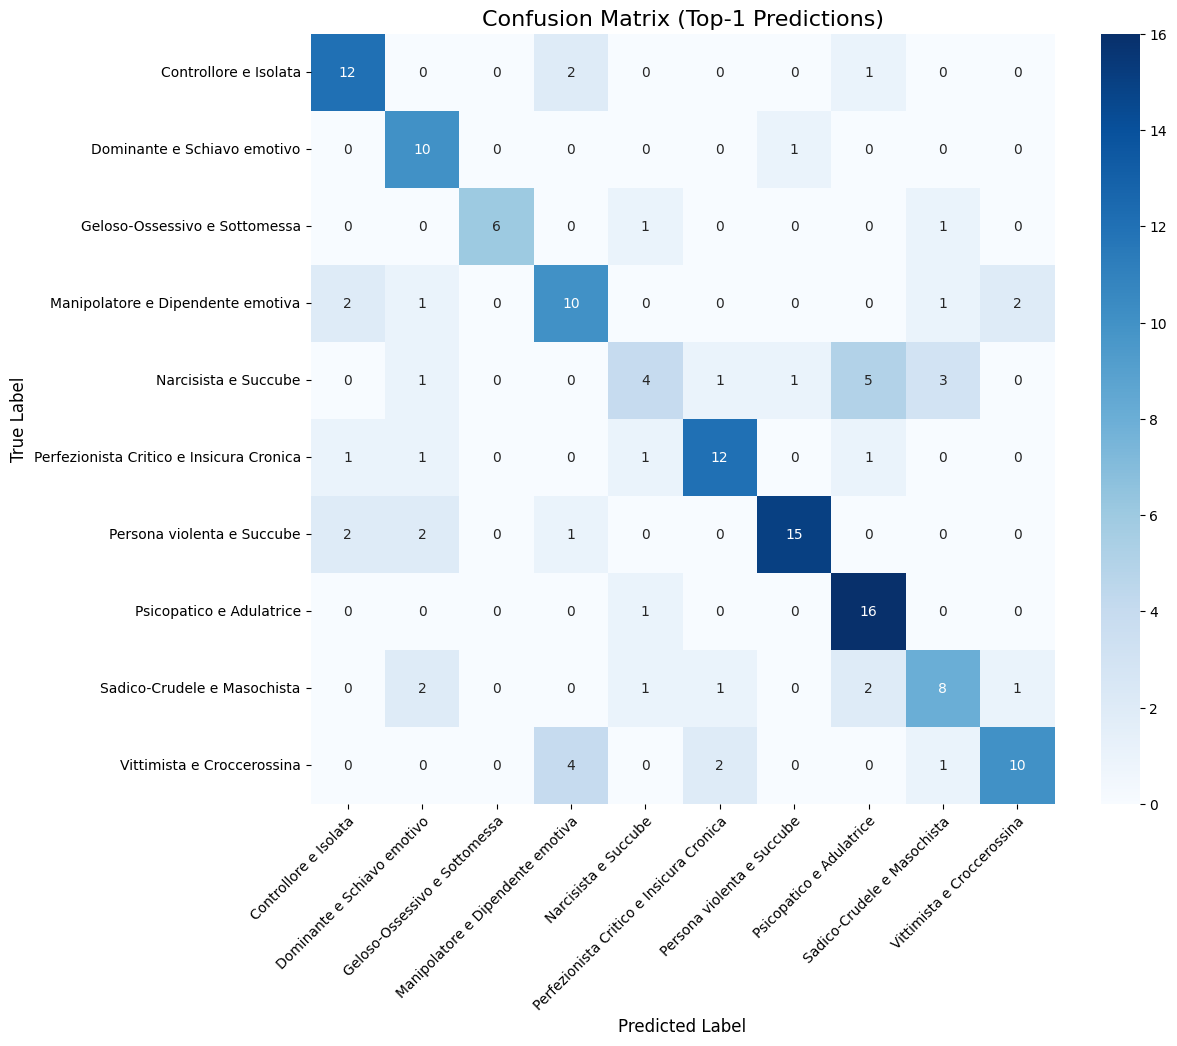

In [5]:
# SECTION 4: EXECUTION AND EVALUATION

# 1. Initialize the classifier
svm_classifier = TurnBasedClassifier(random_state=RANDOM_STATE)

# 2. Train the model
svm_classifier.train(df_train_turns)

# 3. Run the final evaluation with Top-K metrics
test_json_path = os.path.join(PROCESSED_DATA_DIR, TEST_FILE)
final_results = svm_classifier.evaluate(test_json_path, verbose=True)

# 4. Visualize the final results
print("\n" + "="*60)
print("VISUAL EVALUATION RESULTS")
print("="*60)
svm_classifier.plot_evaluation_results(
    y_true=final_results['y_true'],
    y_pred=final_results['y_pred']
)


Starting model training...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Training complete. Best model parameters found: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


DETAILED PERFORMANCE REPORT (Based on Averaged Turn Probabilities)
                                         Precision Recall (Top-1 Acc) F1-Score Top-2 Accuracy Top-3 Accuracy  Support
Class                                                                                                                
Controllore e Isolata                       70.59%             80.00%   75.00%         86.67%         93.33%       15
Dominante e Schiavo emotivo                 58.82%             90.91%   71.43%         90.91%         90.91%       11
Geloso-Ossessivo e Sottomessa              100.00%             75.00%   85.71%         75.00%         75.00%        8
Manipolatore e Dipendente emotiva           58.82%             62.50%   60.61%         81.25%         87.50%       16
Narcisista e Succube                      

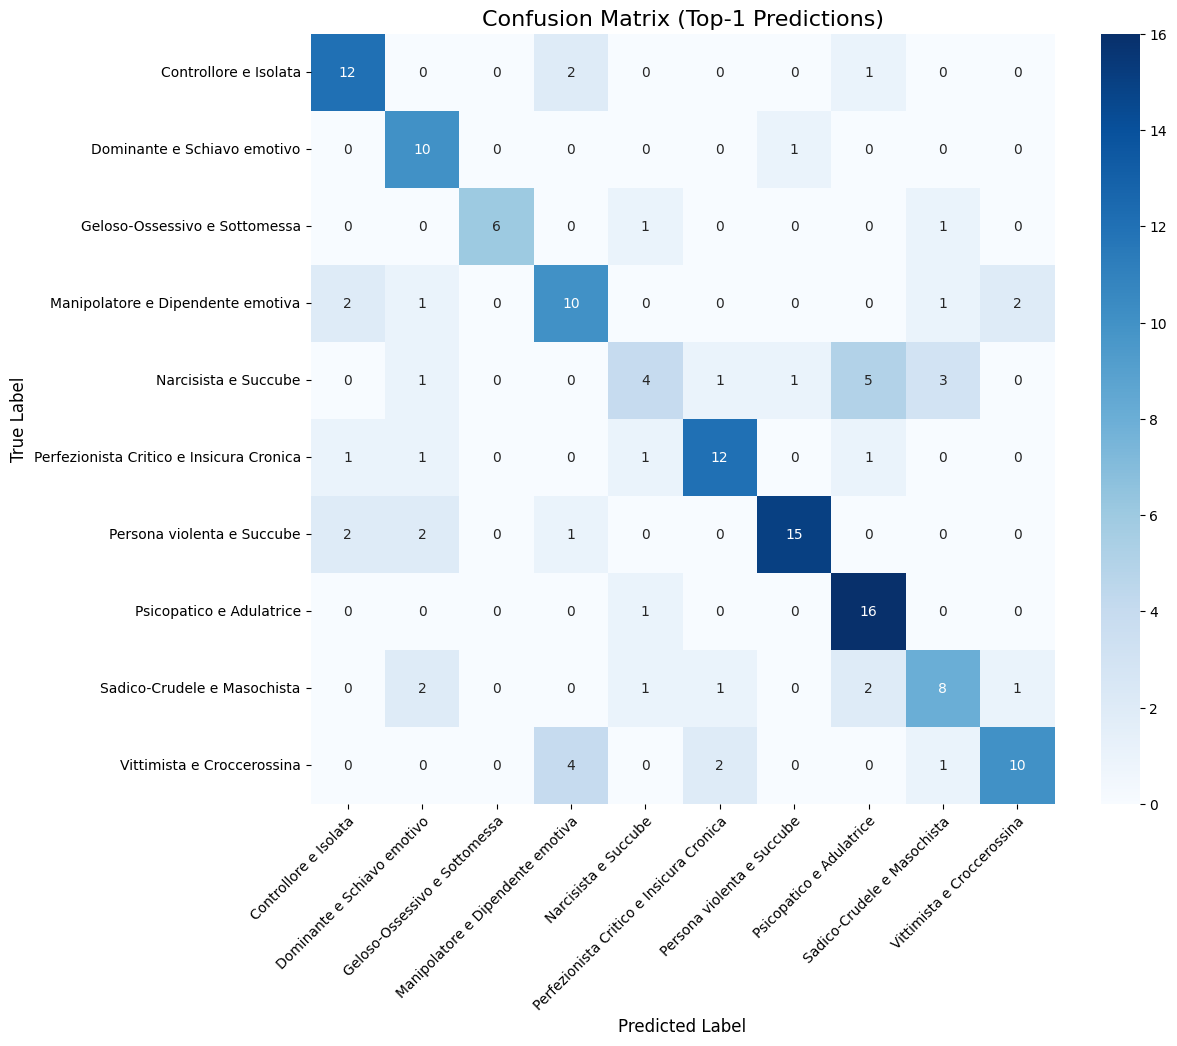

In [ ]:
# SECTION 4: EXECUTION AND EVALUATION

# 1. Initialize the classifier
svm_classifier = TurnBasedClassifier(random_state=RANDOM_STATE)

# 2. Train the model
svm_classifier.train(df_train_turns)

# 3. Run the final evaluation with Top-K metrics
test_json_path = os.path.join(PROCESSED_DATA_DIR, TEST_FILE)
final_results = svm_classifier.evaluate(test_json_path, verbose=True)

# 4. Visualize the final results
print("\n" + "="*60)
print("VISUAL EVALUATION RESULTS")
print("="*60)
svm_classifier.plot_evaluation_results(
    y_true=final_results['y_true'],
    y_pred=final_results['y_pred']
)